In [ ]:
%%capture
import sys
import time
import argparse
import numpy as np

import orca

### LCOG table/variable/model definitions
from lcog import datasources # /lcog/datasources.py
from lcog import variables   # /lcog/variables.py
from lcog import models      # /lcog/models.py

### UrbanSim Template imports
from urbansim.models import util
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import OLSRegressionStep

##  Register all estimated models with Orca

This step takes the persisted models (.yaml files) in the /configs directory and makes them Python model objects that we can run in simulation.  The yaml files store model coefficients/settings.

In [2]:
mm.initialize()

Registering model step 'elcm5'
Registering model step 'tenure_choice_model'
Registering model step 'repm_sf_detached'
Registering model step 'repm_industrial'
Registering model step 'repm_duplex_townhome'
Registering model step 'elcm12'
Registering model step 'tenure_choice_model2'
Registering model step 'elcm6'
Registering model step 'tenure_choice_model1'
Registering model step 'elcm9'
Registering model step 'elcm1'
Registering model step 'elcm11'
Registering model step 'elcm2'
Registering model step 'repm_multifamily'
Registering model step 'elcm7'
Registering model step 'repm_retail'
Registering model step 'elcm10'
Registering model step 'elcm3'
Registering model step 'elcm8'
Registering model step 'elcm13'
Registering model step 'repm_residential'
Registering model step 'elcm15'
Registering model step 'elcm4'
Registering model step 'repm_office'
Registering model step 'hlcm2'
Registering model step 'household_relocation_choice_model'
Registering model step 'elcm14'
Registering mod

## Optionally, fix the random seed for replicability

Microsimulation models like UrbanSim will display run-to-run variability in results if the random seed is allowed to vary (the default).   This can be useful for gauging the breadth of possible outcomes.  But fixing the random seed makes the result repeatable.

In [3]:
np.random.seed(1)

## Initialize the network accessibility calculator

This pre-processing step makes `pandana` accessibility queries run much faster.  Each parcel is associated with the nearest node, and node-to-node impedance distances within some buffer are pre-calculated.

In [4]:
orca.run(['build_networks'])

Running step 'build_networks'


/home/janowicz/clients/lcog/lcog/lcog/datasources.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  craigslist.rent[craigslist.rent < 100] = 100
/home/janowicz/clients/lcog/lcog/lcog/datasources.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  craigslist.rent[craigslist.rent > 10000] = 10000
/home/janowicz/clients/lcog/lcog/lcog/datasources.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  craigslist.rent_sqft[craigslist.rent_sqft < .2] = .2
/home/janowicz/clients/lcog/lco

Number of nodes is 27052.
Number of edges is 34835.


/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


Precomputing network for distance 5000.
Network precompute starting.
Network precompute done.
Time to execute step 'build_networks': 1.53 s
Total time to execute iteration 1 with iteration value None: 1.53 s


/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


## Household transition

Introduce new households into the region to match control totals.

Household control totals can be pretty arbitrarily detailed and can utilize any household table attributes.

Notice the year argument passed to `orca.run`-  for control-total-based transition (as opposed to growth rate-based), a year is needed the model knows what targets to match.

In [5]:
orca.run(['household_transition'], iter_vars=[2030])

Running iteration 1 with iteration value 2030
Running step 'household_transition'
Total agents before transition: 88839
Total agents after transition: 125199
Time to execute step 'household_transition': 0.13 s
Total time to execute iteration 1 with iteration value 2030: 0.13 s


In [6]:
len(orca.get_table('households').local.query('building_id == -1'))

36360

#### Building_id for new households will be set to -1 (an UrbanSim convention denoting "unplaced" status)

In [7]:
orca.get_table('households').local.tail()

,serialno,persons,cars,income,race_of_head,hispanic_head,age_of_head,workers,children,tenure,recent_mover,building_id
182335,2013000141980,2,0,12600,1,0,62,0,0,1,0,-1
182336,2013001365107,2,3,71000,1,0,59,2,0,1,0,-1
182337,2010000484352,6,2,62800,1,0,31,1,4,1,0,-1
182338,2012000136905,2,2,36000,8,1,25,2,0,1,0,-1
182339,2013000079924,1,1,22000,8,0,82,0,0,2,0,-1


## Jobs transition 

Introduce new households into the region to match control totals.

Employment control totals are typically segmented by sector.

In [8]:
orca.run(['job_transition'], iter_vars=[2030])

Running iteration 1 with iteration value 2030
Running step 'job_transition'
Total agents before transition: 106648
Total agents after transition: 154641
Time to execute step 'job_transition': 0.15 s
Total time to execute iteration 1 with iteration value 2030: 0.15 s


In [9]:
orca.get_table('jobs').local.tail()

,firm_id,sector_id,building_id
178820,1396726,15,-1
178821,1402383,15,-1
178822,1398786,15,-1
178823,1392786,15,-1
178824,1403561,15,-1


In [10]:
##  Where's the relocation models??

In [11]:
orca.run(['household_relocation_choice_model'])

Running step 'household_relocation_choice_model'
Time to execute step 'household_relocation_choice_model': 0.05 s
Total time to execute iteration 1 with iteration value None: 0.05 s


In [12]:
orca.get_table('households').local.tail()

,serialno,persons,cars,income,race_of_head,hispanic_head,age_of_head,workers,children,tenure,recent_mover,building_id
182335,2013000141980,2,0,12600,1,0,62,0,0,1,0,-1
182336,2013001365107,2,3,71000,1,0,59,2,0,1,0,-1
182337,2010000484352,6,2,62800,1,0,31,1,4,1,0,-1
182338,2012000136905,2,2,36000,8,1,25,2,0,1,0,-1
182339,2013000079924,1,1,22000,8,0,82,0,0,2,0,-1


In [13]:
len(orca.get_table('households').local.query('building_id == -1'))

50608

In [15]:
## Household tenure model

In [16]:
orca.get_table('households').tenure.value_counts()

1    72425
2    52774
Name: tenure, dtype: int64

In [17]:
orca.run(['tenure_choice_model1','tenure_choice_model2','tenure_choice_model3'])

Running step 'tenure_choice_model1'
Time to execute step 'tenure_choice_model1': 0.11 s
Running step 'tenure_choice_model2'
Time to execute step 'tenure_choice_model2': 0.07 s
Running step 'tenure_choice_model3'
Time to execute step 'tenure_choice_model3': 0.08 s
Total time to execute iteration 1 with iteration value None: 0.26 s


/home/janowicz/clients/lcog/lcog/lcog/variables.py:578: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(orca.get_table(table_name)[column_to_ln])


In [18]:
orca.get_table('households').tenure.value_counts()

1    75636
2    49563
Name: tenure, dtype: int64

In [19]:
len(orca.get_table('households').local.query('building_id == -1'))

50608

In [20]:
orca.run(['hlcm1', 'hlcm2'])

Running step 'hlcm1'
Disaggregating prop_tenure_1 to buildings from parcels
Calculating proportion tenure 1 for parcels
Calculating number of households for parcels
Disaggregating prop_hispanic_head_1 to buildings from zones
Disaggregating zone_id to households from parcels
Calculating proportion hispanic_head 1 for zones
Calculating number of households for zones
Disaggregating zone_id to buildings from parcels
Disaggregating prop_income_quartile_1 to buildings from zones
Calculating proportion income_quartile 1 for zones
Disaggregating prop_sector_id_4 to buildings from zone_subdistricts
Disaggregating zone_subdistrict_id to jobs from parcels
Calculating proportion sector_id 4 for zone_subdistricts
Calculating number of jobs for zone_subdistricts
Disaggregating zone_subdistrict_id to buildings from parcels
Disaggregating mean_residential_units to buildings from blocks
Calculating mean_residential_units of buildings for blocks
Disaggregating block_id to buildings from parcels
Disaggre

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Disaggregating mean_non_residential_sqft to buildings from locations
Calculating mean_non_residential_sqft of buildings for locations
Disaggregating location_id to buildings from parcels
Iteration 1: 9998 of 14494 valid choices
Iteration 2: 14115 of 14494 valid choices
Iteration 3: 14491 of 14494 valid choices
Iteration 4: 14494 of 14494 valid choices
Time to execute step 'hlcm1': 1.15 s
Running step 'hlcm2'
Disaggregating prop_building_type_id_1110 to buildings from blocks
Calculating proportion building_type_id 1110 for blocks
Calculating number of buildings for blocks
Disaggregating ratio_households_to_residential_units to buildings from parcels
Calculating ratio of households to residential_units for parcels
Calculating number of households for parcels
Calculating sum_residential_units of buildings for parcels
Iteration 1: 24829 of 36114 valid choices
Iteration 2: 34812 of 36114 valid choices
Iteration 3: 36080 of 36114 valid choices
Iteration 4: 36113 of 36114 valid choices
Iterat

In [21]:
len(orca.get_table('households').local.query('building_id == -1'))

0

In [22]:
len(orca.get_table('jobs').local.query('building_id == -1'))

47993

In [23]:
orca.run(['elcm1', 'elcm2', 'elcm3', 'elcm4', 'elcm5', 'elcm6',
   'elcm7', 'elcm8', 'elcm9', 'elcm10', 'elcm11', 'elcm12',
   'elcm13', 'elcm14'])

Running step 'elcm1'
Disaggregating density_buildings to buildings from blocks
Calculating density of buildings for blocks
Calculating number of buildings for blocks
Disaggregating block_id to buildings from parcels
Calculating sum_acres of parcels for blocks
Disaggregating prop_repm_id_duplex_townhome to buildings from blocks


/home/janowicz/clients/lcog/lcog/lcog/variables.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  buildings.repm_id[buildings.building_type_id.isin(retail_btypes)] = 'retail'
/home/janowicz/clients/lcog/lcog/lcog/variables.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  buildings.repm_id[buildings.building_type_id.isin(industrial_btypes)] = 'industrial'
/home/janowicz/clients/lcog/lcog/lcog/variables.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  buildings.repm_id[buil

Calculating proportion repm_id duplex_townhome for blocks
Disaggregating acres to buildings from parcels
Disaggregating total_households to buildings from parcels
Calculating number of households for parcels
Disaggregating prop_repm_id_res_sf_detached to buildings from blocks
Calculating proportion repm_id res_sf_detached for blocks
Iteration 1: 65 of 212 valid choices
Iteration 2: 212 of 212 valid choices
Time to execute step 'elcm1': 0.75 s
Running step 'elcm2'
Disaggregating density_jobs to buildings from parcels
Calculating density of jobs for parcels
Calculating number of jobs for parcels
Disaggregating prop_building_type_id_1220 to buildings from parcels
Calculating proportion building_type_id 1220 for parcels
Calculating number of buildings for parcels
Disaggregating prop_sector_id_2 to buildings from block_groups
Disaggregating block_group_id to jobs from parcels
Calculating proportion sector_id 2 for block_groups
Calculating number of jobs for block_groups
Disaggregating block

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Disaggregating zone_id to buildings from parcels
Disaggregating density_households to buildings from blocks
Calculating density of households for blocks
Calculating number of households for blocks
Disaggregating block_id to households from parcels
Disaggregating mean_year_built to buildings from blocks
Calculating mean_year_built of buildings for blocks
Disaggregating sum_persons_5_md_offpeak_travel_time to buildings from zones
Calculating sum_persons of households for zones
Disaggregating zone_id to households from parcels
Iteration 1: 592 of 771 valid choices
Iteration 2: 771 of 771 valid choices
Time to execute step 'elcm2': 1.32 s
Running step 'elcm3'
Disaggregating total_jobs_15_md_offpeak_travel_time to buildings from zones
Calculating number of jobs for zones
Disaggregating prop_building_type_id_5100 to buildings from parcels
Calculating proportion building_type_id 5100 for parcels
Calculating number of buildings for parcels
Disaggregating mean_acres to buildings from blocks
Cal

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandas/core/generic.py:7441: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  return_indexers=True)


Iteration 1: 1010 of 2148 valid choices
Iteration 2: 2120 of 2148 valid choices
Iteration 3: 2148 of 2148 valid choices
Time to execute step 'elcm3': 1.62 s
Running step 'elcm4'
Disaggregating prop_sector_id_4 to buildings from blocks
Calculating proportion sector_id 4 for blocks
Calculating number of jobs for blocks
Disaggregating sum_children_ave_4400_flat to buildings from parcels
Calculating sum_children of households for parcels
Disaggregating mean_year_built to buildings from block_groups
Calculating mean_year_built of buildings for block_groups
Disaggregating prop_building_type_id_5100 to buildings from blocks
Calculating proportion building_type_id 5100 for blocks
Calculating number of buildings for blocks
Iteration 1: 2152 of 3899 valid choices
Iteration 2: 3843 of 3899 valid choices
Iteration 3: 3899 of 3899 valid choices
Time to execute step 'elcm4': 1.93 s
Running step 'elcm5'
Disaggregating mean_non_residential_sqft_ave_400_flat to buildings from parcels
Calculating mean_n

In [24]:
len(orca.get_table('jobs').local.query('building_id == -1'))

12

In [25]:
orca.run(['repm_sf_detached', 'repm_duplex_townhome', 'repm_multifamily',
                    'repm_industrial', 'repm_retail', 'repm_office'])

Running step 'repm_sf_detached'
Disaggregating density_buildings to buildings from blocks
Calculating density of buildings for blocks
Calculating number of buildings for blocks
Disaggregating block_id to buildings from parcels
Calculating sum_acres of parcels for blocks
Disaggregating prop_building_type_id_5100 to buildings from zones
Disaggregating zone_id to buildings from parcels
Calculating proportion building_type_id 5100 for zones
Calculating number of buildings for zones
Disaggregating prop_building_type_id_1220 to buildings from zone_subdistricts
Disaggregating zone_subdistrict_id to buildings from parcels
Calculating proportion building_type_id 1220 for zone_subdistricts
Calculating number of buildings for zone_subdistricts
Disaggregating prop_income_quartile_4 to buildings from block_groups
Disaggregating block_group_id to households from parcels
Calculating proportion income_quartile 4 for block_groups
Calculating number of households for block_groups
Disaggregating block_gr

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Disaggregating mean_income_ave_4400_linear to buildings from parcels
Calculating mean_income of households for parcels
Disaggregating prop_sector_id_2 to buildings from zones
Disaggregating zone_id to jobs from parcels
Calculating proportion sector_id 2 for zones
Calculating number of jobs for zones
Disaggregating sum_residential_units to buildings from zones
Calculating sum_residential_units of buildings for zones
Disaggregating sum_non_residential_sqft to buildings from zone_subdistricts
Calculating sum_non_residential_sqft of buildings for zone_subdistricts
Disaggregating total_jobs to buildings from block_groups
Calculating number of jobs for block_groups
Disaggregating block_group_id to jobs from parcels
Disaggregating mean_age_of_head_ave_2800_flat to buildings from parcels
Calculating mean_age_of_head of households for parcels
Disaggregating total_jobs_10_am_peak_travel_time to buildings from zones
Time to execute step 'repm_sf_detached': 2.95 s
Running step 'repm_duplex_townhom

In [26]:
orca.run(['feasibility', 'residential_developer', 'non_residential_developer'])

Running step 'feasibility'
Disaggregating pred_retail_price_ave_800_linear to site_proposals from parcels
Calculating mean_pred_retail_price of buildings for parcels
Disaggregating pred_industrial_price_ave_800_linear to site_proposals from parcels
Calculating mean_pred_industrial_price of buildings for parcels
Disaggregating pred_office_price_ave_800_linear to site_proposals from parcels
Calculating mean_pred_office_price of buildings for parcels
Disaggregating pred_duplex_townhome_price_ave_800_linear to site_proposals from parcels
Calculating mean_pred_duplex_townhome_price of buildings for parcels
Disaggregating pred_sf_detached_price_ave_800_linear to site_proposals from parcels
Calculating mean_pred_sf_detached_price of buildings for parcels
Disaggregating pred_multifamily_price_ave_800_linear to site_proposals from parcels
Calculating mean_pred_multifamily_price of buildings for parcels
Disaggregating mean_sqft_per_unit_ave_800_linear to site_proposals from parcels
Calculating m

/home/janowicz/udst/developer/developer/sqftproforma.py:727: RuntimeWarning: invalid value encountered in greater
  mask *= np.nan_to_num(heights) > df.max_height.values + .01
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Computing feasibility for form office
Computing feasibility for form residential
Computing feasibility for form retail
Computing feasibility for form residential_office
Computing feasibility for form retail_office
Computing feasibility for form residential_retail
Computing feasibility for form mix_non_residential
Computing feasibility for form mix_all
Time to execute step 'feasibility': 64.06 s
Running step 'residential_developer'
Number of agents: 125,199
Number of agent spaces: 162,629.7412675584
Current average vacancy = 0.23
Target average vacancy = 0.50, target of new units = 86,318.55360423651
306,144 feasible buildings before running developer
Sum of net units that are profitable: 1,599,446


/home/janowicz/clients/lcog/lcog/lcog/models.py:684: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  target_units_btype = target_units.loc[btype].get_value('target_units')


Adding 2,069 buildings with 29,558 residential_units
306,144 feasible buildings after running developer
Unplaced households before: 0
Unplaced households after: 2910
Unplaced jobs before: 12
Unplaced jobs after: 8622
Time to execute step 'residential_developer': 1.58 s
Running step 'non_residential_developer'
Calculating sum_job_spaces of buildings for parcels
Number of agents: 154,641
Number of agent spaces: 119,606
Current average vacancy = -0.29
Target average vacancy = 0.33, target of new units = 111,648.291523179
306,144 feasible buildings before running developer


/home/janowicz/udst/urbansim_parcels/urbansim_parcels/utils.py:997: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  concat_df = pd.concat([old_df, new_df], verify_integrity=True)


Sum of net units that are profitable: 5,712,212
Adding 827 buildings with 61,909 job_spaces
306,144 feasible buildings after running developer
Unplaced households before: 2910
Unplaced households after: 3727
Unplaced jobs before: 8622
Unplaced jobs after: 17180
Time to execute step 'non_residential_developer': 1.34 s
Total time to execute iteration 1 with iteration value None: 66.99 s


/home/janowicz/udst/urbansim_parcels/urbansim_parcels/utils.py:800: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  pd.concat([drop_buildings, prev_drops]))


In [35]:
feas = orca.get_table('feasibility').local.query('form=="residential"')  ## Summarize residential by zone_district_id
feas['zone_district_id'] = orca.get_table('parcels').zone_district_id
feas['zone_id'] = orca.get_table('parcels').zone_id

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [37]:
feas['profit_per_sqft'] = feas.max_profit / feas.residential_sqft
feas.groupby('zone_district_id').profit_per_sqft.mean()

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


zone_district_id
1     1162.266417
2      904.732597
3      980.590766
4     1068.452890
5      977.341787
6      854.888281
10     977.022563
Name: profit_per_sqft, dtype: float64

In [ ]:
## Try with residential REPM (craigslist), and then re-plot profitability surface

In [43]:
import geopandas as gpd
zone_geoms = gpd.read_file('data/zones/zones.geojson').set_index('zone_id')
zone_geoms['mean_profit_sqft'] = feas.groupby('zone_id').profit_per_sqft.mean()
zone_geoms['mean_profit_sqft'] = zone_geoms['mean_profit_sqft'].fillna(0)

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


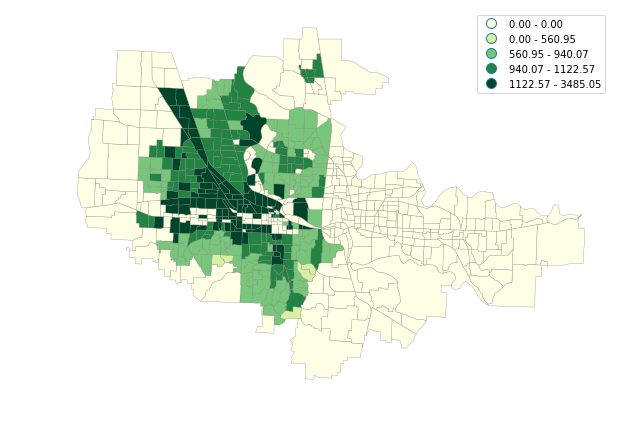

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 8))
ax = f.gca()
kw = dict(column='mean_profit_sqft', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.3)
zone_geoms.plot(scheme='Quantiles', ax=ax, **kw)
ax.set_axis_off()

In [28]:
orca.add_injectable('forecast_year', 2011)
orca.run(['generate_indicators'])

Running step 'generate_indicators'
Calculating sum_non_residential_sqft of buildings for parcels
Calculating sum_non_residential_sqft of buildings for zones
Disaggregating zone_id to buildings from parcels
Calculating number of jobs for zones
Disaggregating zone_id to jobs from parcels
Calculating number of households for zones
Disaggregating zone_id to households from parcels
Calculating sum_residential_units of buildings for zones
Calculating sum_job_spaces of buildings for zones
Calculating sum_residential_units of buildings for parcels
Calculating number of households for parcels
Calculating density of jobs for parcels
Calculating number of jobs for parcels
Calculating mean_income of households for parcels
Calculating density of buildings for parcels
Calculating number of buildings for parcels
Calculating density of households for parcels
Time to execute step 'generate_indicators': 13.16 s
Total time to execute iteration 1 with iteration value None: 13.16 s
